Loading Data...


2025-12-30 22:00:12,455 - INFO - Data loaded successfully from ../data/raw/Fraud_Data.csv. Shape: (151112, 11)
2025-12-30 22:00:12,738 - INFO - Data loaded successfully from ../data/raw/IpAddress_to_Country.csv. Shape: (138846, 3)
2025-12-30 22:00:14,669 - INFO - Starting Geolocation Merge...
2025-12-30 22:00:14,907 - INFO - Geolocation Merge Completed.


Training Model on full data...
Sampling data for SHAP explanations...
Calculating SHAP values...
Generating Plots...


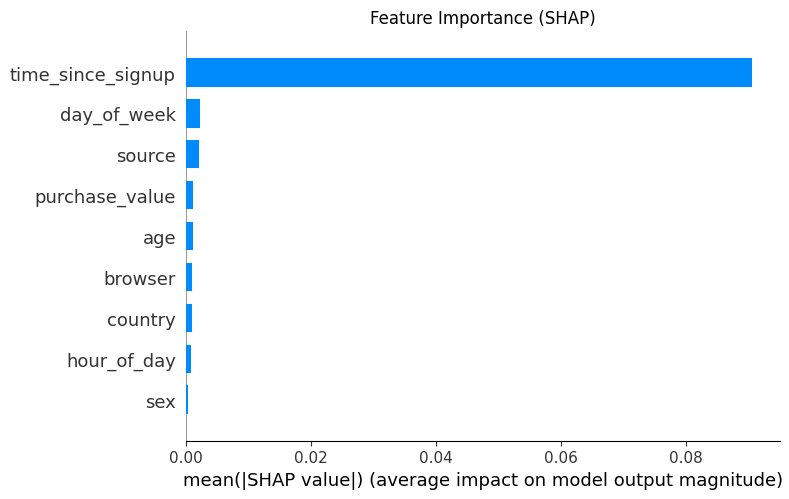

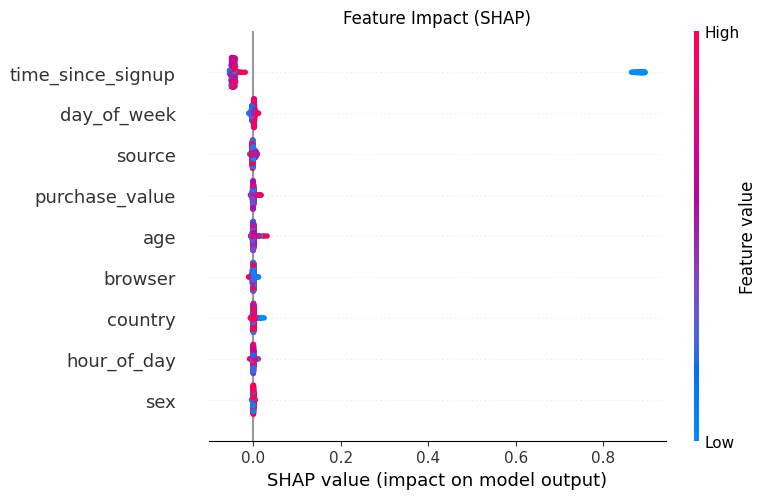

In [1]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

# 1. Setup
sys.path.append(os.path.abspath(os.path.join('..')))
from src.preprocess import load_data, clean_data, feature_engineering, merge_geolocation

# 2. Load & Process Data
print("Loading Data...")
df = load_data('../data/raw/Fraud_Data.csv')
ip_df = load_data('../data/raw/IpAddress_to_Country.csv')
df = clean_data(df)
df = feature_engineering(df)
df = merge_geolocation(df, ip_df)

# 3. Prepare X and y
X = df.drop(['class', 'user_id', 'signup_time', 'purchase_time', 'device_id', 
             'ip_address', 'ip_address_int', 'lower_bound_ip_address', 
             'upper_bound_ip_address'], axis=1)
y = df['class']

# 4. Encode Categoricals
cats = ['source', 'browser', 'sex', 'country']
enc = OrdinalEncoder()
X[cats] = enc.fit_transform(X[cats].astype(str))

# 5. Train Model (Train on ALL data for best accuracy)
print("Training Model on full data...")
model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X, y)

# 6. Calculate SHAP on a SAMPLE (The Professional Shortcut)
print("Sampling data for SHAP explanations...")
X_sample = X.sample(n=1000, random_state=42)

print("Calculating SHAP values...")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# 7. Handle SHAP Output Shape (Fixing your previous error)
if isinstance(shap_values, list):
    shap_vals_target = shap_values[1]
elif len(np.array(shap_values).shape) == 3:
    shap_vals_target = shap_values[:, :, 1]
else:
    shap_vals_target = shap_values

# 8. Plot
print("Generating Plots...")
plt.figure()
plt.title("Feature Importance (SHAP)")
shap.summary_plot(shap_vals_target, X_sample, plot_type="bar", show=False)
plt.show()

plt.figure()
plt.title("Feature Impact (SHAP)")
shap.summary_plot(shap_vals_target, X_sample, show=False)
plt.show()